In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Normalize the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    #transforms.Normalize((0.1307,),(0.3081,))
])

In [3]:
# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train = false telling it is not training data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 105298150.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76233916.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32581862.96it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13202029.64it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Split the dataset into training and testing sets
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

In [5]:
# Create data loaders
# shuffle to prevent model learning order of training data
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# vali data for hypertuning + prevent overfitting
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)
# the data to test the model on
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [6]:
# The model basic architecture
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # max pool layer
        # layer 1
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # fully connected layers
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        #return F.log_softmax(x) no need to apply this as cross entropy automatically applies this?

In [7]:
import torch.nn.functional as F

# the model with batch normalisation
# but is taking more time
class CNNModelWithBatchNorm(nn.Module):
    def __init__(self):
        super(CNNModelWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# Define the model to be used
model = CNNModel()
# decide a loss function
criterion = nn.CrossEntropyLoss()
# set learning rate alpha = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10 # improves accuracy but increas time
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [8]:
# another architecture model I found online
# much faster maybe due to more pooling used and gives almost the same accuracy
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #layer 1
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # layer 2
        self.conv2_drop = nn.Dropout2d() # I don't know about this layer
        self.fc1 = nn.Linear(320, 50) # fully connected layers
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # max_pooling done after each convolution
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Softmax used for the last layer

In [9]:
# Training loop for model 2
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [10]:
# Evaluate the model on the testing set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

Accuracy: 98.66%


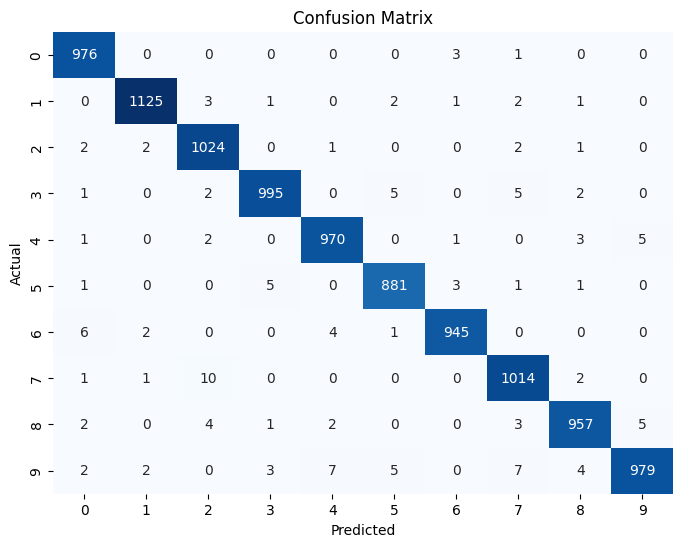

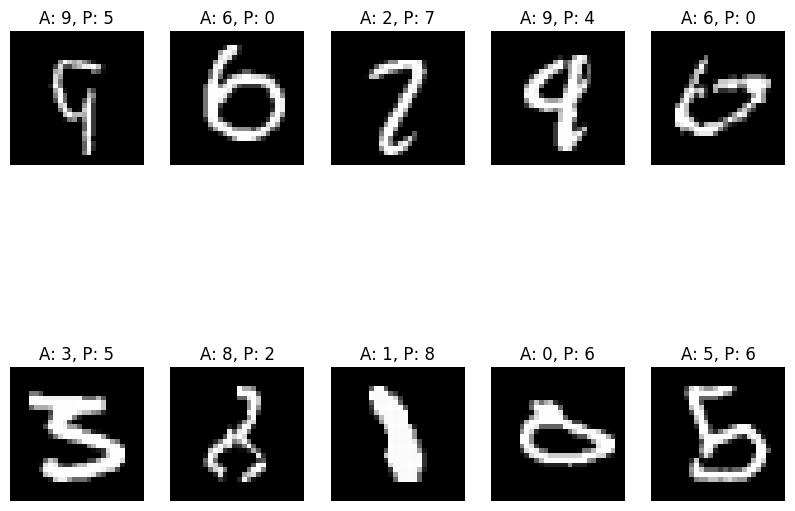

In [11]:
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualize some misclassified images
misclassified_idx = [i for i in range(len(all_labels)) if all_labels[i] != all_preds[i]]

plt.figure(figsize=(10, 8))
for i, idx in enumerate(misclassified_idx[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_dataset[idx][0].squeeze(), cmap='gray')
    plt.title(f'A: {all_labels[idx]}, P: {all_preds[idx]}')
    plt.axis('off')
plt.show()